# Data Integration Pipeline for Movies Reviews

The goal of this Data Integration Pipeline is to handle BigData with the right techniques and tools. The datasets of choice are four datasets, two of which have more than one million instances. Thoughout the Pipeline, these datasets are cleaned, preprocessed and transformed for being able to have higher quality outcomes in other processes, such as predictions or better quality statistical analysis.

### Data Explanation

The data was sourced from kaggle, from two different profiles and with significant time difference. The data is retrieved originally from the Rotten Tomatoes website, both have over a million instances, my goal is to clean and preprocess the data to be able to merge both of the Reviews datasets, to be ableww to perform a sentiment analysis with Hadoop. 

**Methods & Tools Used:**
- Parallel Computing
- Apache PySpark
- Hadoop Distributed File System (HDFS)
- NLP Preprocessing
- Linux / UNIX

df1 source: https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset?select=rotten_tomatoes_movies.csv

df2 sourse: https://www.kaggle.com/datasets/andrezaza/clapper-massive-rotten-tomatoes-movies-and-reviews?select=rotten_tomatoes_movie_reviews.csv

In [2]:
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import regexp_replace, col

import concurrent.futures

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
from tabulate import tabulate

from IPython.display import Image, display


In [3]:
#Reviews Df
dfr1 = pd.read_csv('antiguo/rotten_tomatoes_critic_reviews.csv')
dfr2 = pd.read_csv('rotten tomatoes/rotten_tomatoes_movie_reviews.csv')

#Movies DF
dfm1 = pd.read_csv('antiguo/rotten_tomatoes_movies.csv')
dfm2 = pd.read_csv('rotten tomatoes/rotten_tomatoes_movies.csv')

## Rows and Columns

In [4]:
print(dfr1.shape)
print(dfr2.shape)
print(dfm1.shape)
print(dfm2.shape)

(1130017, 8)
(1444963, 11)
(17712, 22)
(143258, 16)


# Looking at the dfs


In [5]:
for i in (dfr1,dfr2,dfm1,dfm2):
    display(i.head(1))

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...


,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,http://www.deseretnews.com/article/700003233/B...


,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76


,id,title,audienceScore,tomatoMeter,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix
0,space-zombie-bingo,Space Zombie Bingo!,50.0,NaN,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,George Ormrod,"George Ormrod,John Sabotta",NaN,NaN,NaN


## Common Columns DFR1 and DFR2
- Critic Name
- Review Date
- Top critic
- Publisher Name
- Review Content
- Review Score

## Common Columns DFM1 and DFM2
- Movie_Title
- Directors
- Genres
- Content Rating


In [6]:
dfr1.rename(columns={'rotten_tomatoes_link':'id'}, inplace=True)
dfm1.rename(columns={'rotten_tomatoes_link':'id'},  inplace=True)

dfr2.rename(columns={'criticName': 'critic_name', 'creationDate':'review_date', 'isTopCritic':'top_critic', 'publicatioName': 'publisher_name',
                      'reviewText': 'review_content','originalScore':'review_score', 'reviewState': 'review_type'}, inplace=True)
dfm2.rename(columns={'title':'movie_title'}, inplace=True)



In [7]:
print('DFR1 NULL')
display(dfr1.isnull().sum())
print('DFR2 NULL')
display(dfr2.isnull().sum())

DFR1 NULL


id                     0
critic_name        18529
top_critic             0
publisher_name         0
review_type            0
review_score      305936
review_date            0
review_content     65806
dtype: int64

DFR2 NULL


id                     0
reviewId               0
review_date            0
critic_name            0
top_critic             0
review_score      435218
review_type            0
publisher_name         0
review_content     69225
scoreSentiment         0
reviewUrl         210925
dtype: int64

In [8]:
dfr2.drop(columns=['reviewId','scoreSentiment','reviewUrl' ],inplace=True)

In [9]:
for i in dfr1,dfm1,dfr2,dfm2:
    display(i.head(2))

,id,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."


,id,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19


,id,review_date,critic_name,top_critic,review_score,review_type,publisher_name,review_content
0,beavers,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...
1,blood_mask,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...


,id,movie_title,audienceScore,tomatoMeter,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix
0,space-zombie-bingo,Space Zombie Bingo!,50.0,NaN,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,George Ormrod,"George Ormrod,John Sabotta",NaN,NaN,NaN
1,the_green_grass,The Green Grass,NaN,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Tiffany Edwards,Tiffany Edwards,NaN,NaN,NaN


In [10]:
for i in dfr1,dfr2:
    display(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130017 entries, 0 to 1130016
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   id              1130017 non-null  object
 1   critic_name     1111488 non-null  object
 2   top_critic      1130017 non-null  bool  
 3   publisher_name  1130017 non-null  object
 4   review_type     1130017 non-null  object
 5   review_score    824081 non-null   object
 6   review_date     1130017 non-null  object
 7   review_content  1064211 non-null  object
dtypes: bool(1), object(7)
memory usage: 61.4+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444963 entries, 0 to 1444962
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   id              1444963 non-null  object
 1   review_date     1444963 non-null  object
 2   critic_name     1444963 non-null  object
 3   top_critic      1444963 non-null  bool  
 4   review_score    1009745 non-null  object
 5   review_type     1444963 non-null  object
 6   publisher_name  1444963 non-null  object
 7   review_content  1375738 non-null  object
dtypes: bool(1), object(7)
memory usage: 78.5+ MB


None

### We have the same column types

In [11]:
new_column_order = ['id','critic_name', 'top_critic', 'publisher_name', 'review_type', 'review_score', 'review_date', 'review_content']
dfr2 = dfr2[new_column_order]

In [12]:
dfm2.columns

Index(['id', 'movie_title', 'audienceScore', 'tomatoMeter', 'rating',
       'ratingContents', 'releaseDateTheaters', 'releaseDateStreaming',
       'runtimeMinutes', 'genre', 'originalLanguage', 'director', 'writer',
       'boxOffice', 'distributor', 'soundMix'],
      dtype='object')

# PySpark for Preprocessing and Data Integration

In [53]:
spark = SparkSession.builder \
    .appName("New_NLP") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()


## Making Spark Readable DataFrames

In [54]:
sp_dfr1 = spark.createDataFrame(dfr1)
sp_dfr2 = spark.createDataFrame(dfr2)
sp_dfm1 = spark.createDataFrame(dfm1)
sp_dfm2 = spark.createDataFrame(dfm2)


/Users/diegoportillaamarillas/opt/anaconda3/envs/Data_Integration/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:479: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


Dropping rows to free memory

In [55]:
sp_dfr1 = sp_dfr1.na.drop()
sp_dfr2 = sp_dfr2.na.drop()

## Using Spark for tokenizing the Reviews

In [56]:
# Tokenization
tokenizer = Tokenizer(inputCol="review_content", outputCol="tokens")
sp_dfr1 = tokenizer.transform(sp_dfr1)
sp_dfr2 = tokenizer.transform(sp_dfr2)


### Ignoring Non-Alpha Numeric Values

I'm incluiding this step for the future steps. So all the data can be completly free of symbols that could affect the outcome of the Hadoop Jobs later on.

In [57]:
sp_dfr1 = sp_dfr1.withColumn("review_content", regexp_replace(col("review_content"), "[^a-zA-Z0-9\s,;]", ""))
sp_dfr2 = sp_dfr2.withColumn("review_content", regexp_replace(col("review_content"), "[^a-zA-Z0-9\s,;]", ""))


In [18]:
sp_dfr2.show(2)

23/09/21 10:14:32 WARN TaskSetManager: Stage 0 contains a task of very large size (31408 KiB). The maximum recommended task size is 1000 KiB.


+----------+---------------+----------+--------------------+-----------+------------+-----------+--------------------+--------------------+
|        id|    critic_name|top_critic|      publisher_name|review_type|review_score|review_date|      review_content|              tokens|
+----------+---------------+----------+--------------------+-----------+------------+-----------+--------------------+--------------------+
|   beavers|Ivan M. Lincoln|     false|Deseret News (Sal...|      fresh|       3.5/4| 2003-05-23|Timed to be just ...|[timed, to, be, j...|
|blood_mask|  The Foywonder|     false|       Dread Central|     rotten|         1/5| 2007-06-02|It doesnt matter ...|[it, doesn't, mat...|
+----------+---------------+----------+--------------------+-----------+------------+-----------+--------------------+--------------------+
only showing top 2 rows



23/09/21 10:14:37 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker


### Inner Join to get the Movie title and Review Content together

Here I am merging the reviews DF to their respectives matching DF. It is an Inner Join on the id column

In [58]:
reviews1 = sp_dfr1.join(sp_dfm1, "id", "inner")
reviews2 = sp_dfr2.join(sp_dfm2, "id", "inner")

### Freeing Pyspark memory 

In [59]:
sp_dfr1.unpersist()
sp_dfr2.unpersist()
sp_dfm1.unpersist()
sp_dfm2.unpersist()


DataFrame[id: string, movie_title: string, audienceScore: double, tomatoMeter: double, rating: string, ratingContents: string, releaseDateTheaters: string, releaseDateStreaming: string, runtimeMinutes: double, genre: string, originalLanguage: string, director: string, writer: string, boxOffice: string, distributor: string, soundMix: string]

Selecting just the columns that I need

In [60]:
reviews1 = reviews1.select('movie_title', 'critic_name', 'top_critic', 'publisher_name', 'review_type', 'review_score', 'review_date','review_content' )
reviews2 = reviews2.select('movie_title', 'critic_name', 'top_critic', 'publisher_name', 'review_type', 'review_score', 'review_date','review_content' )

In [61]:
reviews1 = reviews1.na.drop()
reviews2 = reviews2.na.drop()

# Integrated Data

Unifying both of the new reviews dataframes with movies titles, to have just one dataframe for further analysis and manipulation.

In [62]:
merged_df = reviews1.union(reviews2)

In [63]:
merged_df.show(1)

23/09/21 10:25:57 WARN TaskSetManager: Stage 0 contains a task of very large size (22197 KiB). The maximum recommended task size is 1000 KiB.
23/09/21 10:26:01 WARN TaskSetManager: Stage 1 contains a task of very large size (2185 KiB). The maximum recommended task size is 1000 KiB.
23/09/21 10:26:01 WARN TaskSetManager: Stage 2 contains a task of very large size (31408 KiB). The maximum recommended task size is 1000 KiB.
23/09/21 10:26:04 WARN TaskSetManager: Stage 3 contains a task of very large size (3194 KiB). The maximum recommended task size is 1000 KiB.


+----------------+----------------+----------+--------------+-----------+------------+-----------+--------------------+
|     movie_title|     critic_name|top_critic|publisher_name|review_type|review_score|review_date|      review_content|
+----------------+----------------+----------+--------------+-----------+------------+-----------+--------------------+
|100 Bloody Acres|Harvey S. Karten|     false|    Compuserve|      Fresh|          B+| 2013-06-17|Expect this to em...|
+----------------+----------------+----------+--------------+-----------+------------+-----------+--------------------+
only showing top 1 row



In [64]:
reviews1.unpersist()
reviews2.unpersist()

DataFrame[movie_title: string, critic_name: string, top_critic: boolean, publisher_name: string, review_type: string, review_score: string, review_date: string, review_content: string]

### Saving the Data locally

## This is the file that will go to the Hadoop Distributed File System (HDFS) in order to perform a Sentiment Analysis.

In [67]:
merged_df.coalesce(1).write.csv('reviewsjoined.csv', header=True)

23/09/21 10:27:42 WARN TaskSetManager: Stage 27 contains a task of very large size (22197 KiB). The maximum recommended task size is 1000 KiB.
23/09/21 10:27:45 WARN TaskSetManager: Stage 28 contains a task of very large size (2185 KiB). The maximum recommended task size is 1000 KiB.
23/09/21 10:27:45 WARN TaskSetManager: Stage 29 contains a task of very large size (31408 KiB). The maximum recommended task size is 1000 KiB.
23/09/21 10:27:48 WARN TaskSetManager: Stage 30 contains a task of very large size (3194 KiB). The maximum recommended task size is 1000 KiB.


# Stopping The Session

In [68]:
spark.stop()

# NLP Preprocessing with Parallel Computation
Loading the **Integrated Data**

In [28]:
df = pd.read_csv('reviewsjoined.csv/part-00000-742bb049-3108-4621-900e-bb7505bf1843-c000.csv')

In [29]:
df.isnull().sum()

movie_title         5470
critic_name        18521
top_critic             0
publisher_name         0
review_type            0
review_score      748737
review_date            0
review_content    136141
dtype: int64

In [30]:
df.dropna(inplace=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1705455 entries, 0 to 2599429
Data columns (total 8 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   movie_title     object
 1   critic_name     object
 2   top_critic      bool  
 3   publisher_name  object
 4   review_type     object
 5   review_score    object
 6   review_date     object
 7   review_content  object
dtypes: bool(1), object(7)
memory usage: 105.7+ MB


### As the data is to big for my computer to handle, I will do a demonstration on how parallel computing can be used for NLP preprocessing on a sample data of 500 thousand entries

In [32]:
sample_df = df.sample(500000)

In [34]:
sample_df['review_content'] = sample_df['review_content'].astype(str)

def preprocess_text(text):
    text = text.lower()
    
    # Tokenize
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in filtered_words]

    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]

    processed_text = ' '.join(lemmatized_words)
    return processed_text

def parallel_preprocess(data):
    with concurrent.futures.ThreadPoolExecutor(max_workers=6) as executor:
        processed_data = list(executor.map(preprocess_text, data))
    return processed_data

sample_df['review_content'] = parallel_preprocess(sample_df['review_content'])



In [35]:
sample_df['review_content'] = sample_df['review_content'].apply(lambda x: x.replace(",", ""))


In [36]:
sample_df['movie_title'] = sample_df['movie_title'].apply(lambda x: ''.join(e for e in x if e.isalnum() or e.isspace()))


In [37]:
sample_df.head()

,movie_title,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
520015,Man on Wire,Leigh Paatsch,False,Herald Sun (Australia),Fresh,4/5,2018-05-25,onthespot footag eccentr french thrillseek exp...
97758,The Rum Diary,Susan Granger,False,SSG Syndicate,Rotten,4/10,2011-11-02,boozi incoher appeal primarili cultish devote...
2127733,Pineapple Express,Eugene Novikov,False,Film Blather,fresh,B-,2008-08-05,mightili strang movi time funni ; certainli r...
755797,Shanghai Noon,Steve Simels,False,TV Guide,Rotten,2/5,2000-01-01,uneasi mix postmodern selfreferenti arch spag...
451720,I Frankenstein,Marc Savlov,False,Austin Chronicle,Rotten,2/5,2014-01-30,except film tone come surprisingli nighi ar...


### Final touches for better performance with hadoop

### After several attempts on making a sentiment analysis on Hadoop, I encountered that the commas and symbols in the movie titles and in review content affected the outcome of the 'Output'.CSV 

### In this step i replace commas, numbers and symbols.

In [41]:
df.shape

(1705455, 8)

In [38]:
df.head()

,movie_title,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,100 Bloody Acres,Harvey S. Karten,False,Compuserve,Fresh,B+,2013-06-17,Expect this to emerge as the best comichorror ...
2,100 Bloody Acres,Rob Hunter,False,Film School Rejects,Fresh,B,2013-06-21,100 Bloody Acres is extremely funny comedy for...
4,100 Bloody Acres,Don R. Lewis,False,Film Threat,Fresh,3/5,2013-06-21,While the Australian horrorcomedy film 100 Blo...
5,100 Bloody Acres,Nick Schager,True,Time Out,Rotten,1/5,2013-06-25,Its a film thats about as funny andor scary as...
7,100 Bloody Acres,Chuck Bowen,False,Slant Magazine,Fresh,2.5/4,2013-06-26,One sees a film called 100 Bloody Acres expect...


In [42]:
df['review_content'] = df['review_content'].apply(lambda x: x.replace(",", ""))
df['movie_title'] = df['movie_title'].apply(lambda x: ''.join(e for e in x if e.isalnum() or e.isspace()))

## After cleaning and preprocessing and merging data, we have now a really big data set. The next step is to perform the Sentiment Analysis on Hadoop

In [ ]:
df.to_csv('big_movies.csv', header=True, index=False)

# Hadoop Mapred for Average Sentiment Score per Movie

## Uploading the 'big_movies.csv' dataset (just created one cell above) to the Hadoop Distributed File Sysyem (HDFS) and running Mapred Streaming command to be able to work with Python scripts for mapper and reducer.

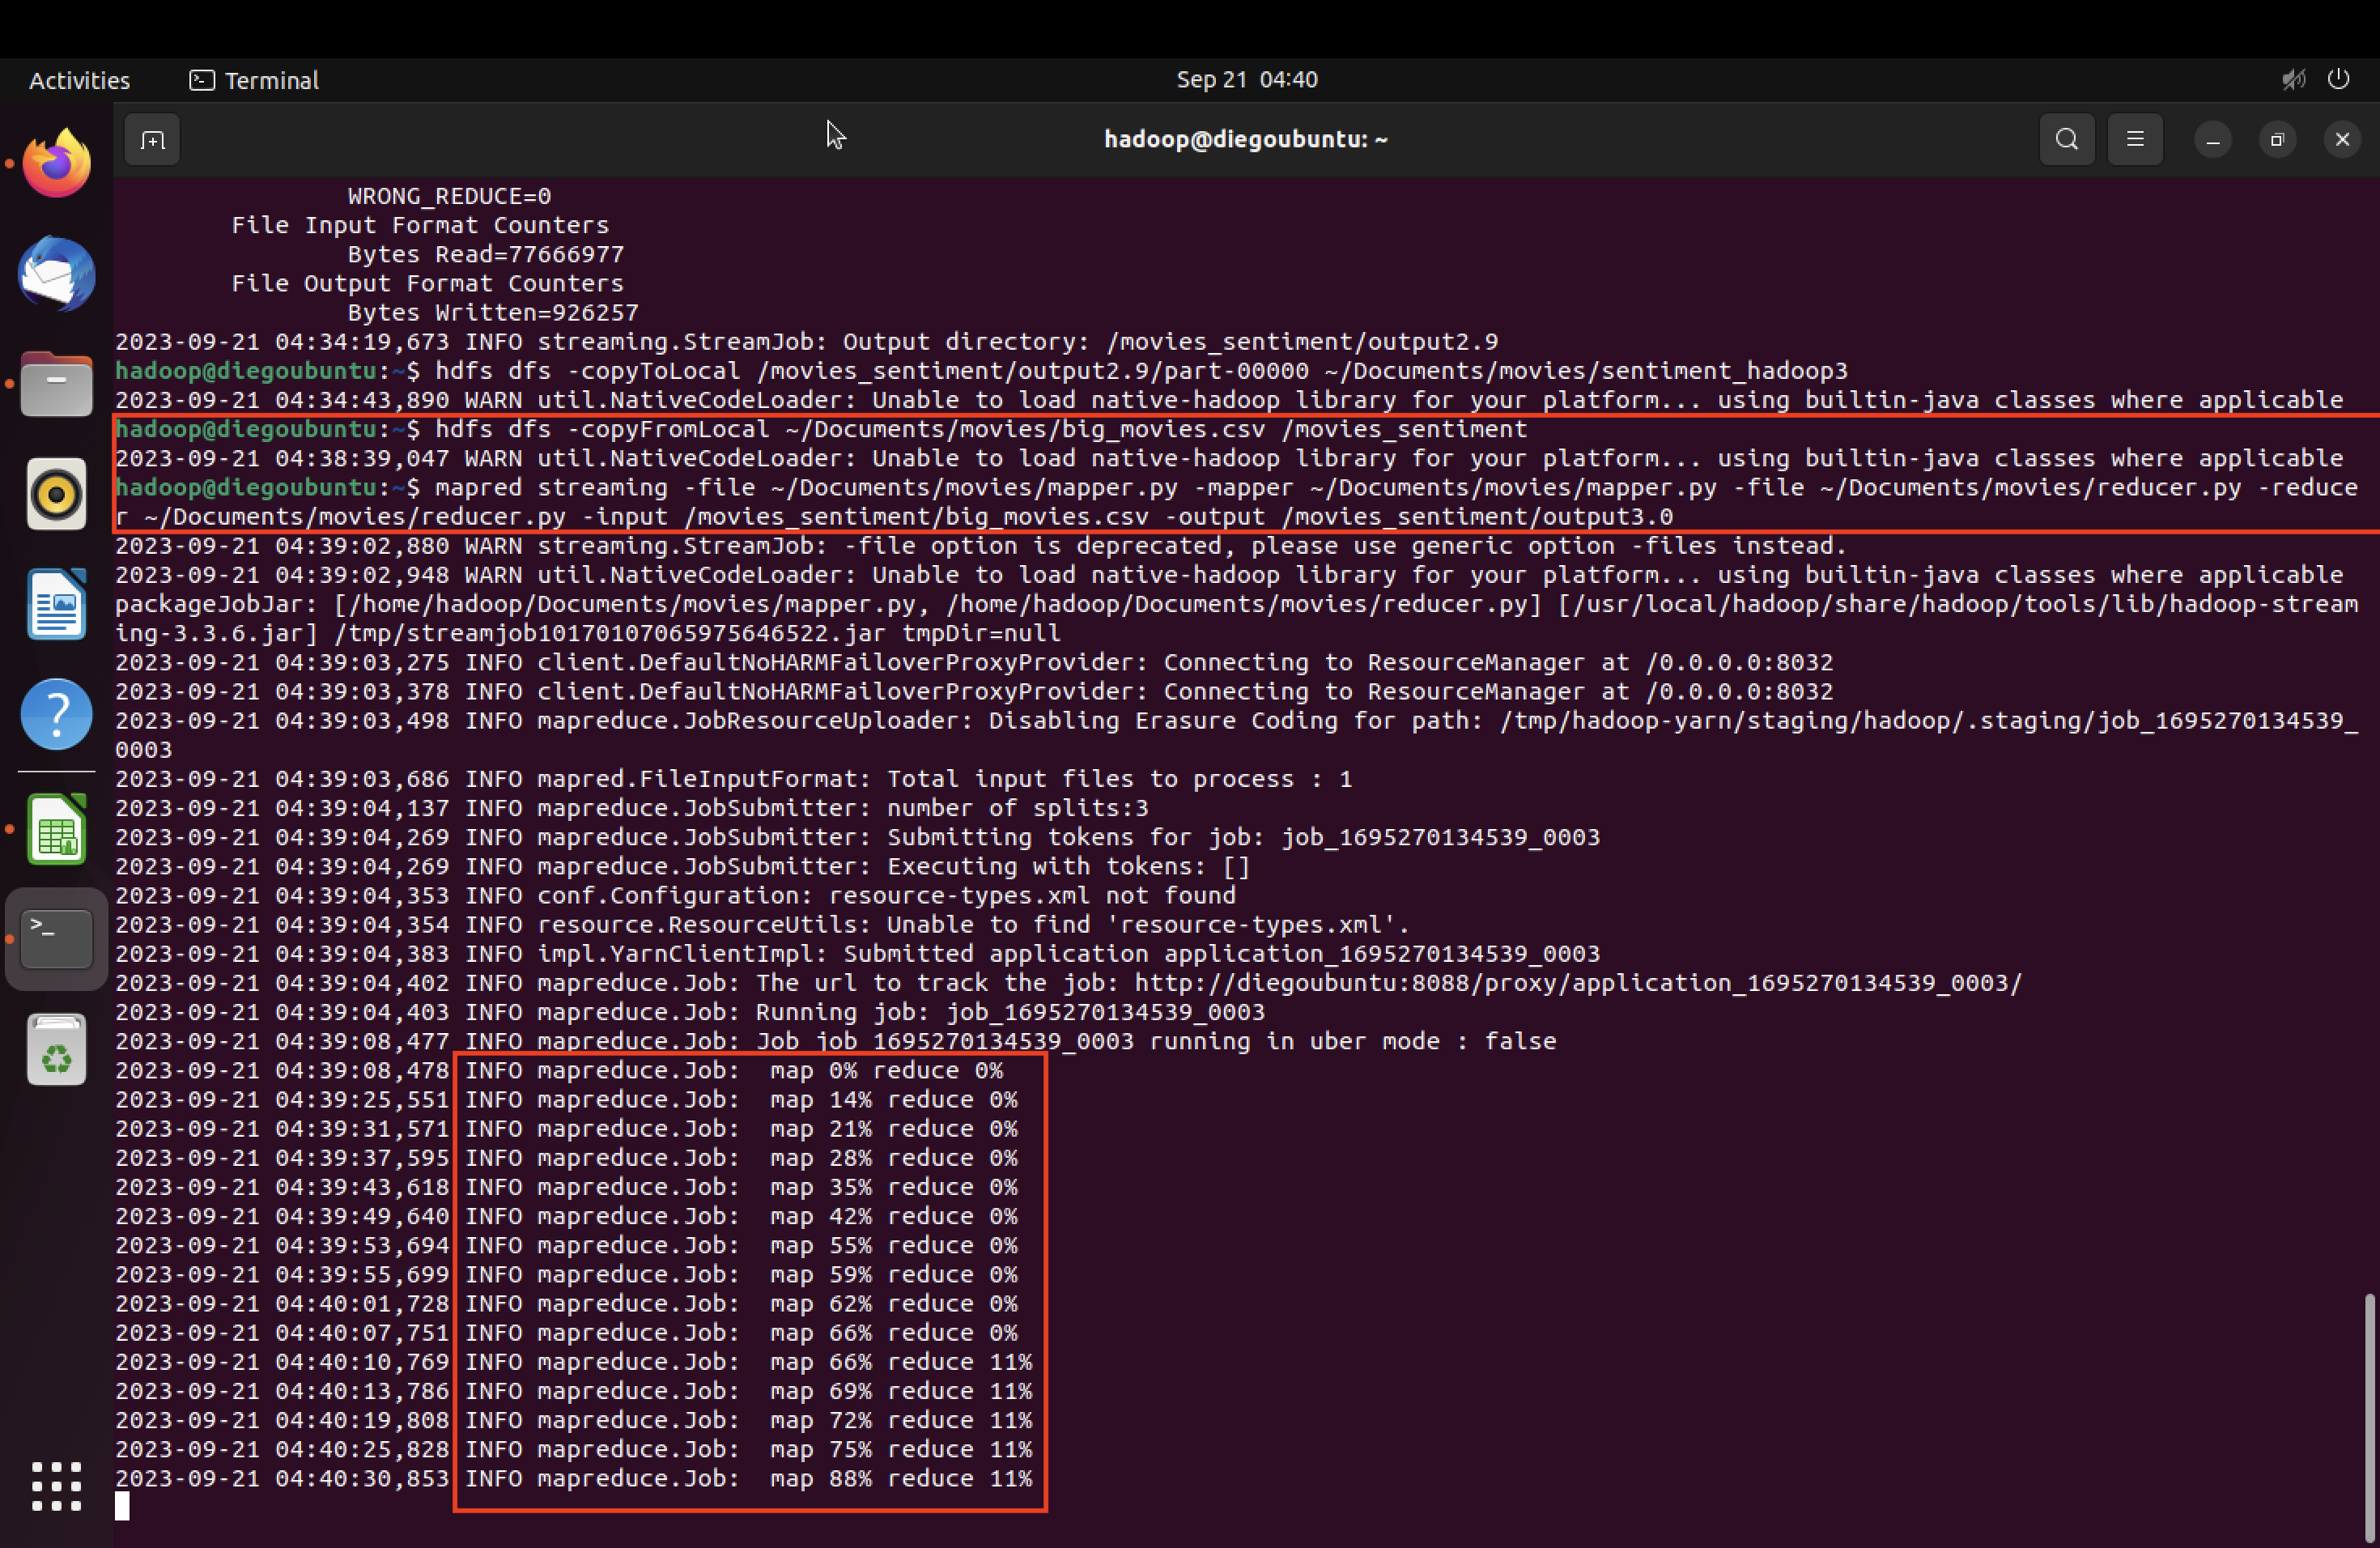

In [ ]:
image_path = 'Captura de pantalla 2023-09-21 a la(s) 6.40.31.png' 

display(Image(filename=image_path))

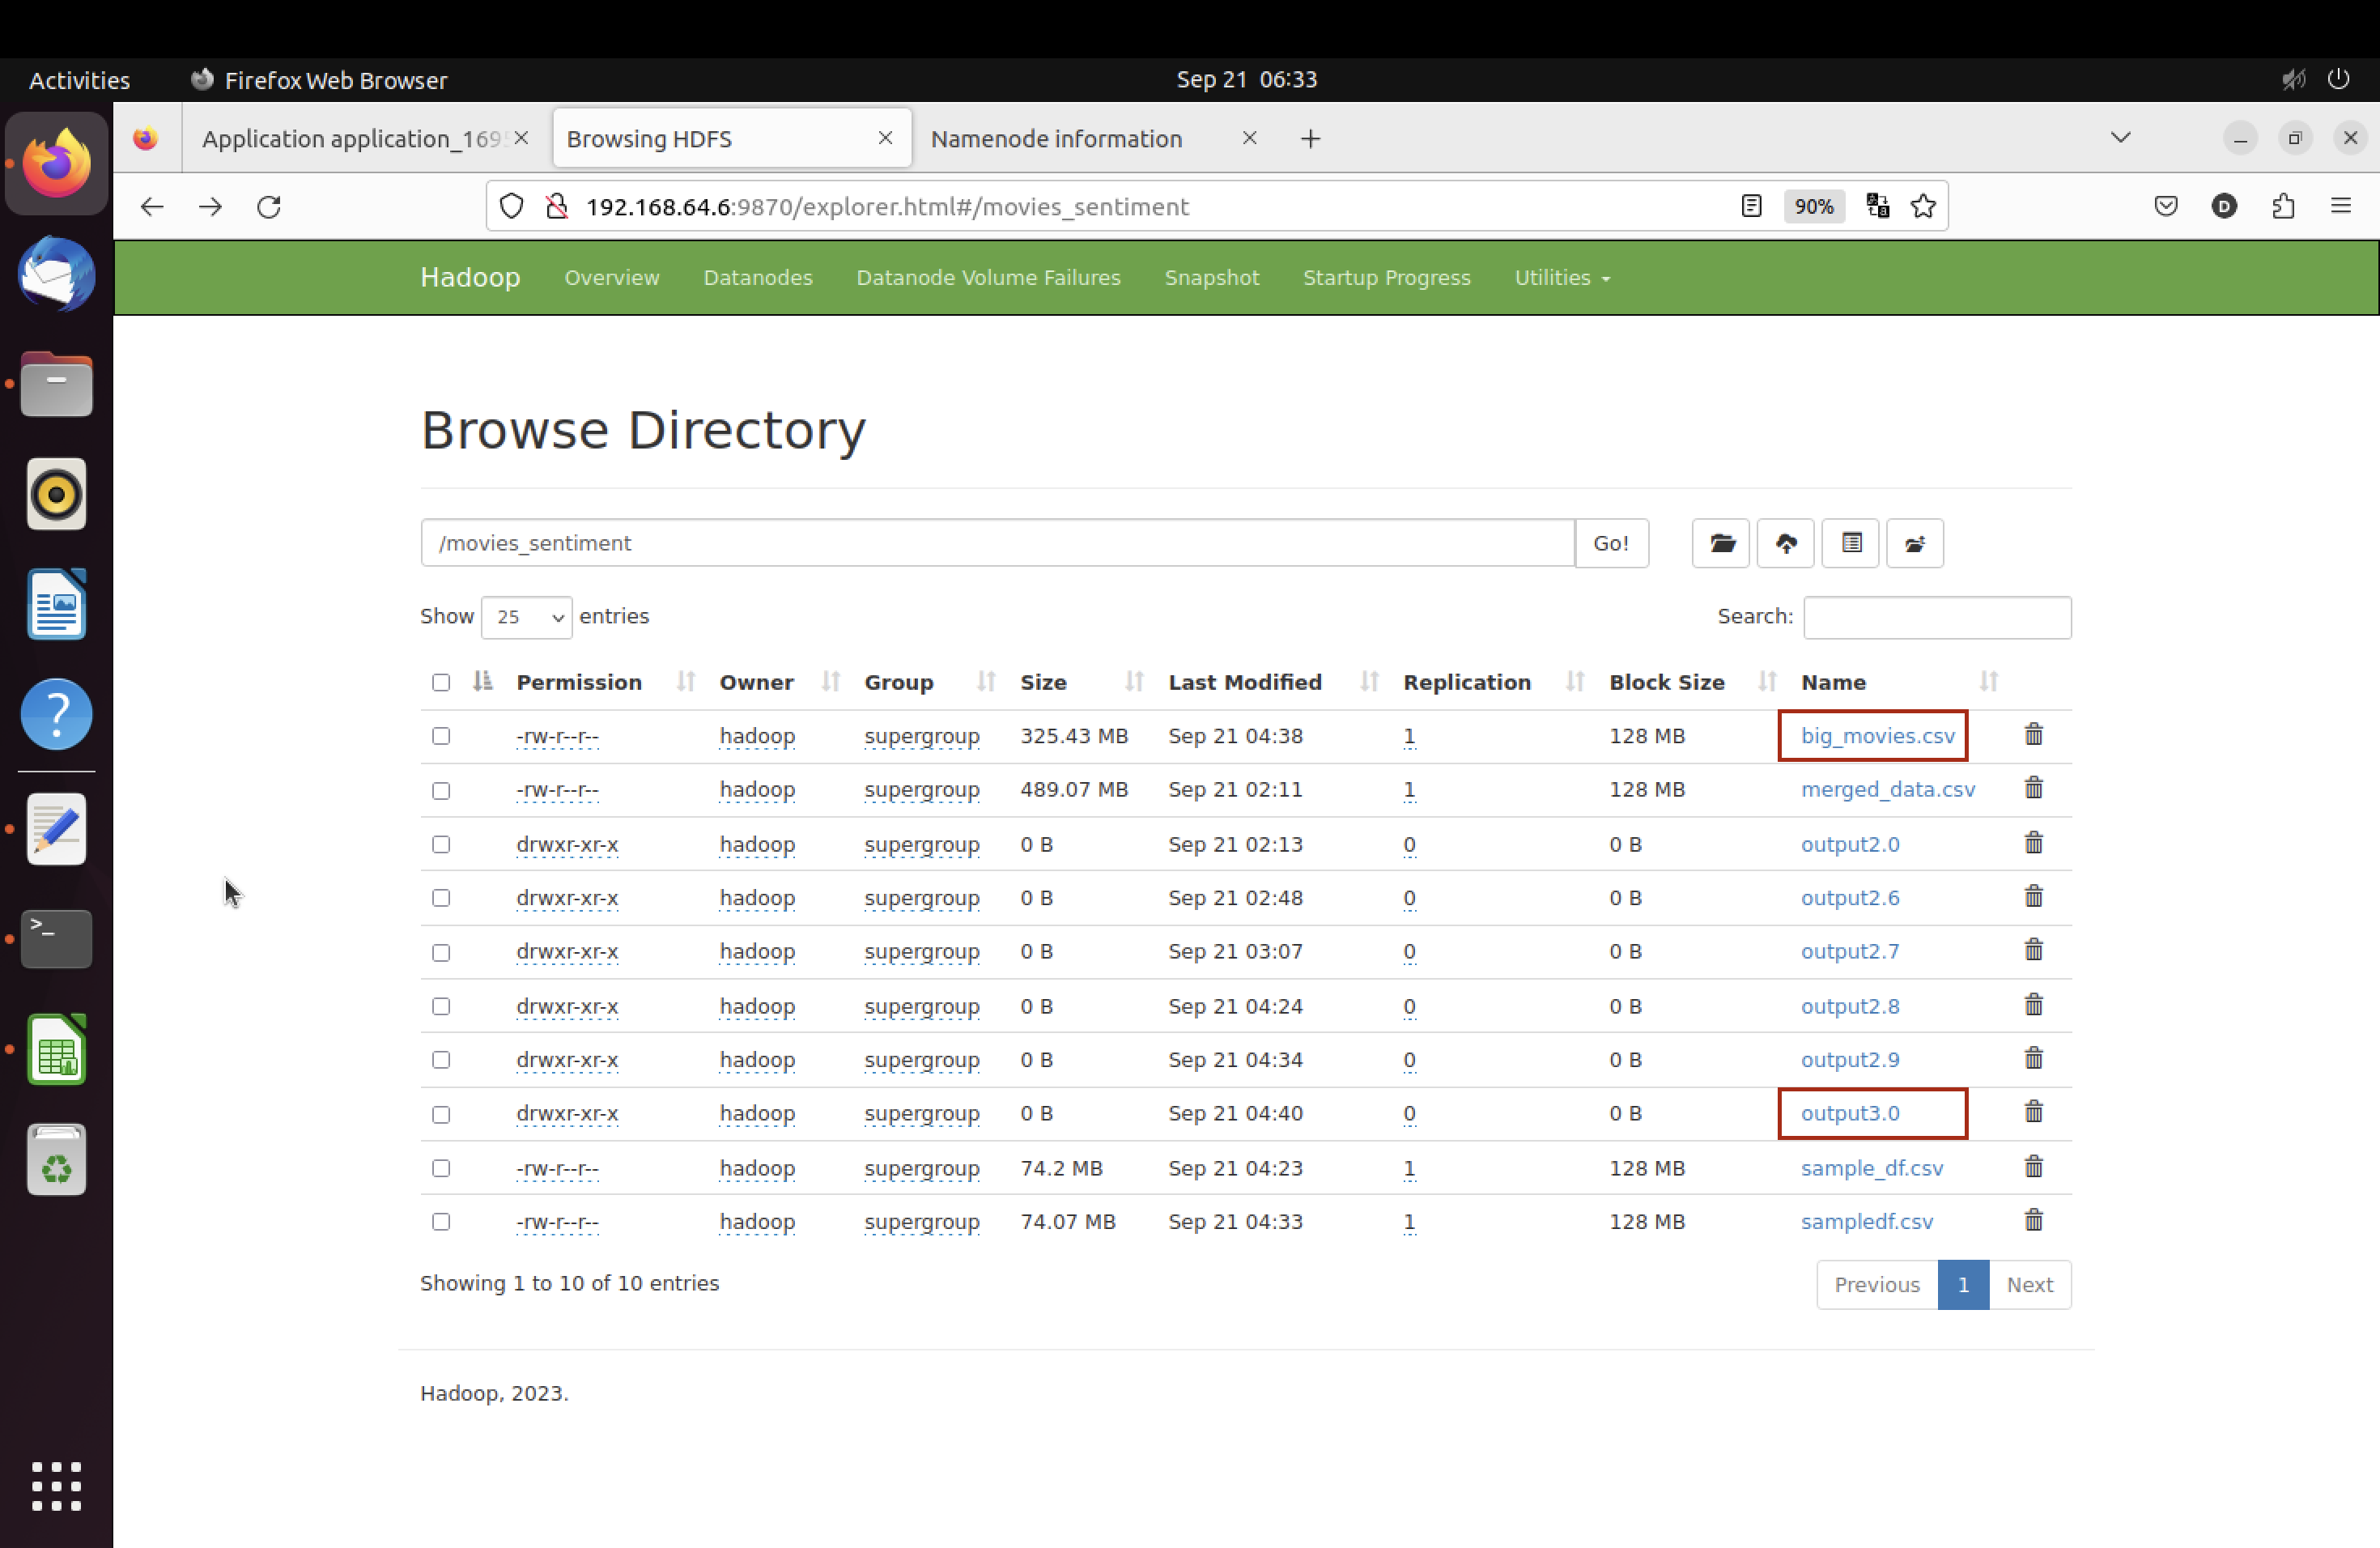

In [ ]:
image_path = 'Captura de pantalla 2023-09-21 a la(s) 8.33.28.png' 

display(Image(filename=image_path))

### Checking the output file created after finishing the Mapred Job

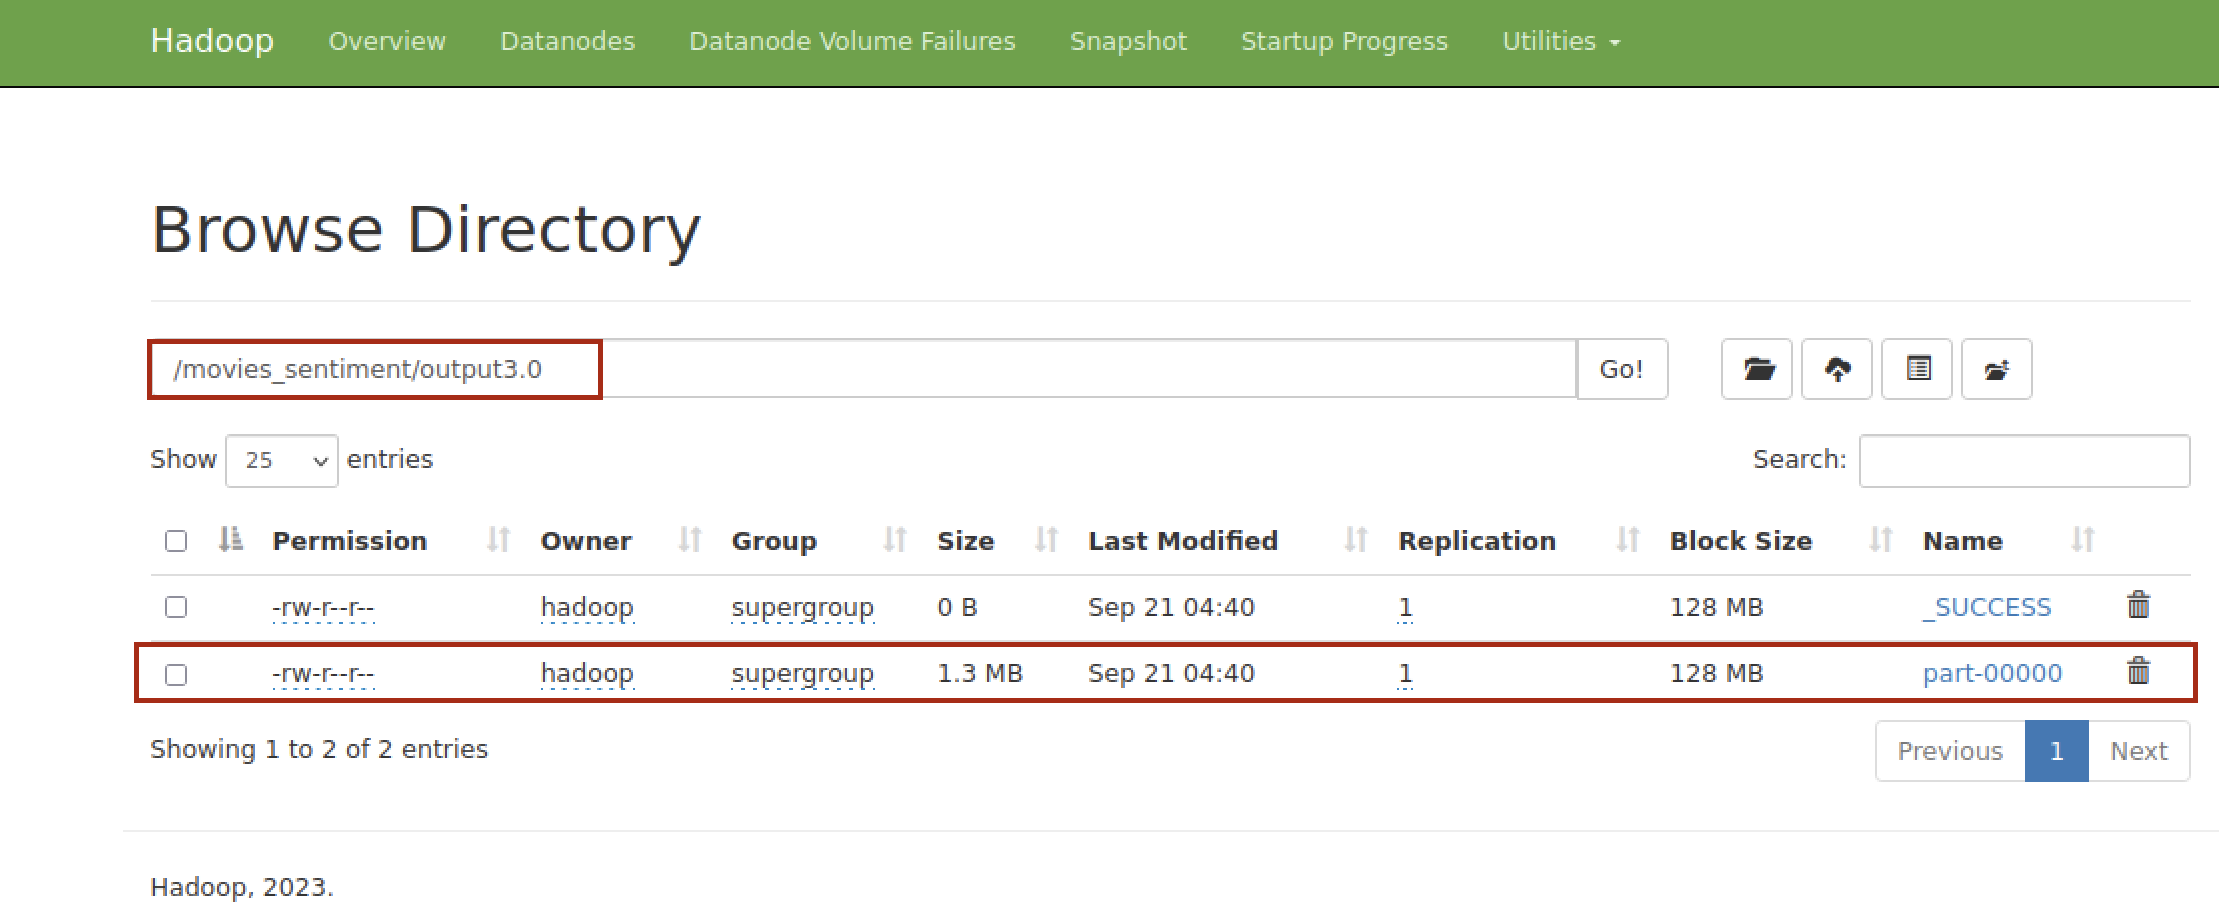

In [ ]:
image_path = 'Captura de pantalla 2023-09-21 a la(s) 8.33.37.png'  # Replace with the actual path to your image
display(Image(filename=image_path))

### Downloading the outputfile 'part-0000' as 'sentiment_hadoop4' in my computer

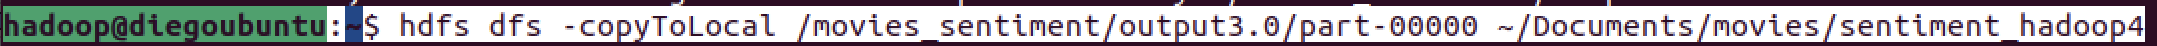

In [ ]:
image_path = 'Captura de pantalla 2023-09-21 a la(s) 8.38.31.png' 
display(Image(filename=image_path))

### Python scripts used for mapper and reducer

## mapper.py
#### This mapper scripts starts by importing the necessary libraries for reading the files that hadoop will input and for making the Sentiment Analysis. The script goes through the input file and splits the lines of the file by the commas, because the input is a CSV, thus interpreting the columns. Then it grabs the movie_title and the review_content to perform the sentiment analysis and store the movie_title as a **KEY** and the sentiment analysis as a **VALUE**, this for all the rows in the file.

#!/usr/bin/env python3

**import sys**

**import nltk**

**from nltk.sentiment.vader import SentimentIntensityAnalyzer**

sia = SentimentIntensityAnalyzer()

for line in sys.stdin:
    
    columns = line.strip().split(',')

    if len(columns) >= 8:
        movie_title = columns[0]
        review_content = columns[7]

        # Perform sentiment analysis on the review content
        sentiment = sia.polarity_scores(review_content)

        # Emit the movie title and sentiment score as key-value pair
        print(f'{movie_title},{sentiment["compound"]}')

## reducer.py

#### The input of this file read by sys library, is the output of the mapper file. Once the mapper has assign each movie with a value, the reducer maps all the movies and put them together agregating their sentiment score, with the counters in the beginning, is how the reducer calculates the average.

#!/usr/bin/env python3

**import sys**

current_movie = None

total_sentiment = 0.0

num_reviews = 0

for line in sys.stdin:

    movie, sentiment = line.strip().split(',')
        
    if current_movie != movie:
        if current_movie is not None:
            # Calculate the average sentiment for the current movie
            average_sentiment = total_sentiment / num_reviews
            print(f'{current_movie},{average_sentiment:.2f}')

        current_movie = movie
        total_sentiment = 0.0
        num_reviews = 0

    sentiment_score = float(sentiment)
    total_sentiment += sentiment_score
    num_reviews += 1

        # Calculate and print the average sentiment for the last movie

if current_movie is not None:

    average_sentiment = total_sentiment / num_reviews

    print(f'{current_movie},{average_sentiment:.2f}')

# After Hadoop

## Uploading the Hadoop output file

In [43]:
hadoop_df = pd.read_csv('sentiment_hadoop4.csv')

In [44]:
hadoop_df.columns

Index(['00 MHz', '0.10\t'], dtype='object')

In [45]:
hadoop_df.rename(columns={'00 MHz':'movie_title', '0.10\t':'avg_sentiment_val'}, inplace=True)

In [46]:
hadoop_df

,movie_title,avg_sentiment_val
0,009 Re Cyborg,-0.01
1,045,-0.46
2,1 2 3 Sun,-0.65
3,1 Angry Black Man,0.33
4,1 Day,0.17
...,...,...
55351,Ópera,0.74
55352,Ôritsu uchûgun Oneamisu no tsubasa Royal Space...,0.33
55353,Öndög,0.41
55354,Über Goober,0.38


## Insights

In [47]:
df.loc[df['review_type'] == 'rotten', 'review_type'] = 'Rotten'
df.loc[df['review_type'] == 'fresh', 'review_type'] = 'Fresh'

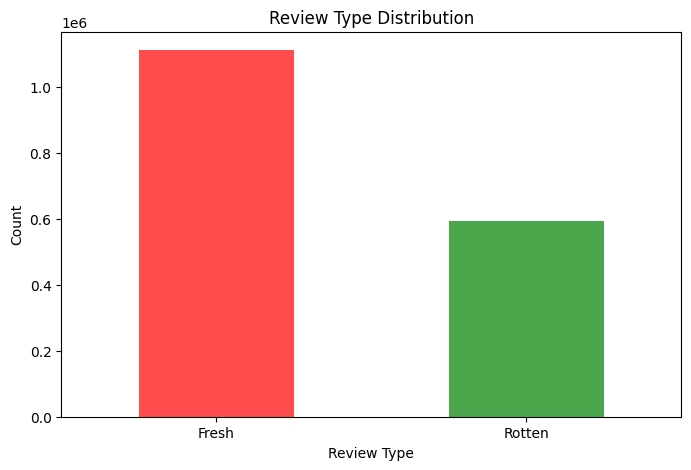

In [48]:
review_type_counts = df['review_type'].value_counts()

plt.figure(figsize=(8, 5))
review_type_counts.plot(kind='bar', color=['red', 'green'], alpha=0.7)
plt.xlabel('Review Type')
plt.ylabel('Count')
plt.title('Review Type Distribution')
plt.xticks(rotation=0)
plt.show()




## Time Series of Reviews

There are still some problems with the data, either the description of the column was abiguous and these are the years of publication of the movies or there are technical problems with the website; there can't be reviews from 1800

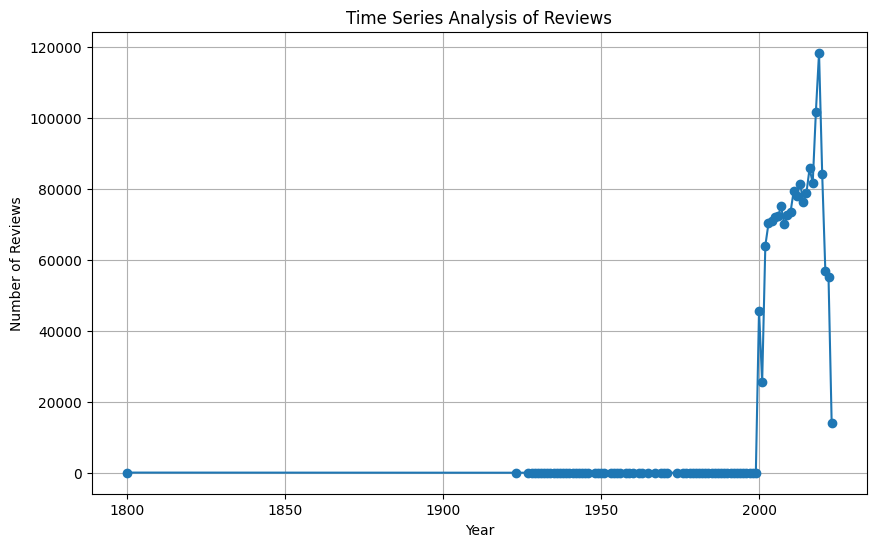

In [49]:
df['review_date'] = pd.to_datetime(df['review_date'])
review_counts_by_year = df.groupby(df['review_date'].dt.year)['movie_title'].count()
plt.figure(figsize=(10, 6))
plt.plot(review_counts_by_year.index, review_counts_by_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Time Series Analysis of Reviews')
plt.grid(True)
plt.show()

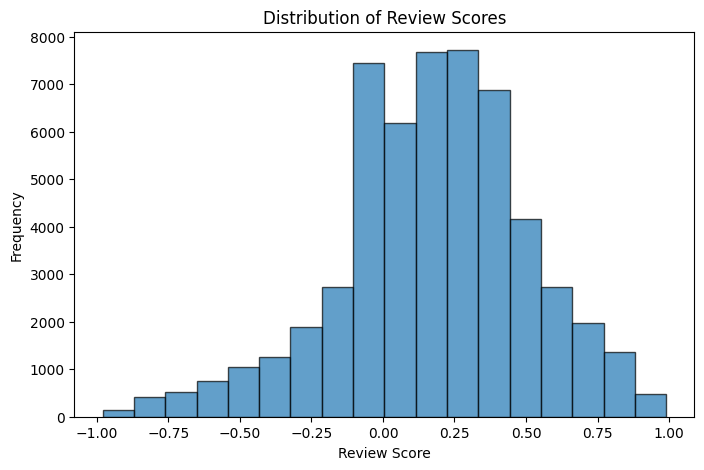

In [50]:
plt.figure(figsize=(8, 5))
plt.hist(hadoop_df['avg_sentiment_val'], bins=18, edgecolor='k', alpha=0.7)
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.title('Distribution of Review Scores')
plt.show()

# Top 20 Movies based on Sentiment Analysis Score

In [51]:
sorted_df = hadoop_df.sort_values(by='avg_sentiment_val', ascending=False)

# Get the top ten rows
top_20 = sorted_df.head(20)

In [ ]:
table = tabulate(top_20, headers='keys', tablefmt='grid', showindex=False)
print('Top 20 Movies Based on Sentiment Analysis')
print(table)

Top 20 Movies Based on Sentiment Analysis
+------------------------------------------------+---------------------+
| movie_title                                    |   avg_sentiment_val |
+================================================+=====================+
| Yowamushi Pedal                                |                0.99 |
+------------------------------------------------+---------------------+
| A                                              |                0.98 |
+------------------------------------------------+---------------------+
| Ratburger                                      |                0.98 |
+------------------------------------------------+---------------------+
| Anukokunda Oka Roju                            |                0.98 |
+------------------------------------------------+---------------------+
| Eika Katappa                                   |                0.97 |
+------------------------------------------------+---------------------+
| Too Bea

In [69]:
from wordcloud import WordCloud

all_text = ' '.join(df['review_content'].astype(str))


## Using Parallel Computing for creating WordCloud

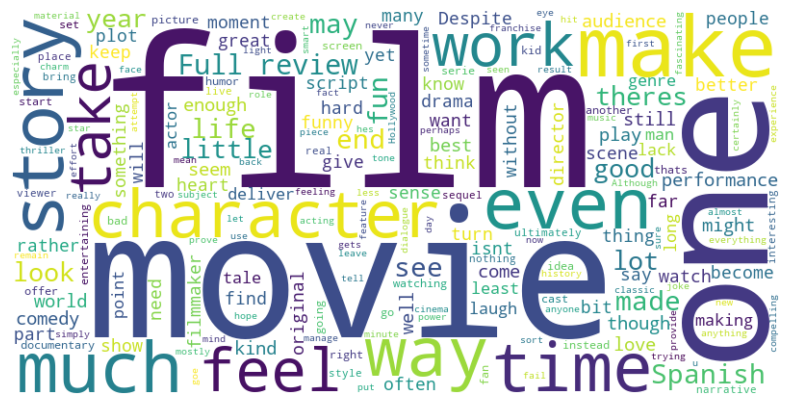

In [71]:
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=200).generate(text)
    return wordcloud

with concurrent.futures.ThreadPoolExecutor(max_workers=6) as executor:
    future = executor.submit(generate_wordcloud, all_text)
    
    wordcloud = future.result()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove the axis
plt.show()


# Conclusions 

The majority of the movies appeare to have a medium to good verbal rating based on the Sentiment Analysis, the bar graph that measure "Fresh" over "Rotten" reinforces suggests us that the Sentiment Analysis is working. There is a visual correlation between the amount of Fresh movies and the distribution of Averages Sentiment Scores. This can create new ways which that movies are rated.

# Evaluation of Tools

I could really feal the great difference that makes working with big data tools like PySpark and Hadoop. I found out that PySpark can be way faster than Hadoop in some processes, but there is a big issue for handling the Memory; Hadoop seemed more reliable and more flexible, allowing to make personalized scripts in different programming languages. 


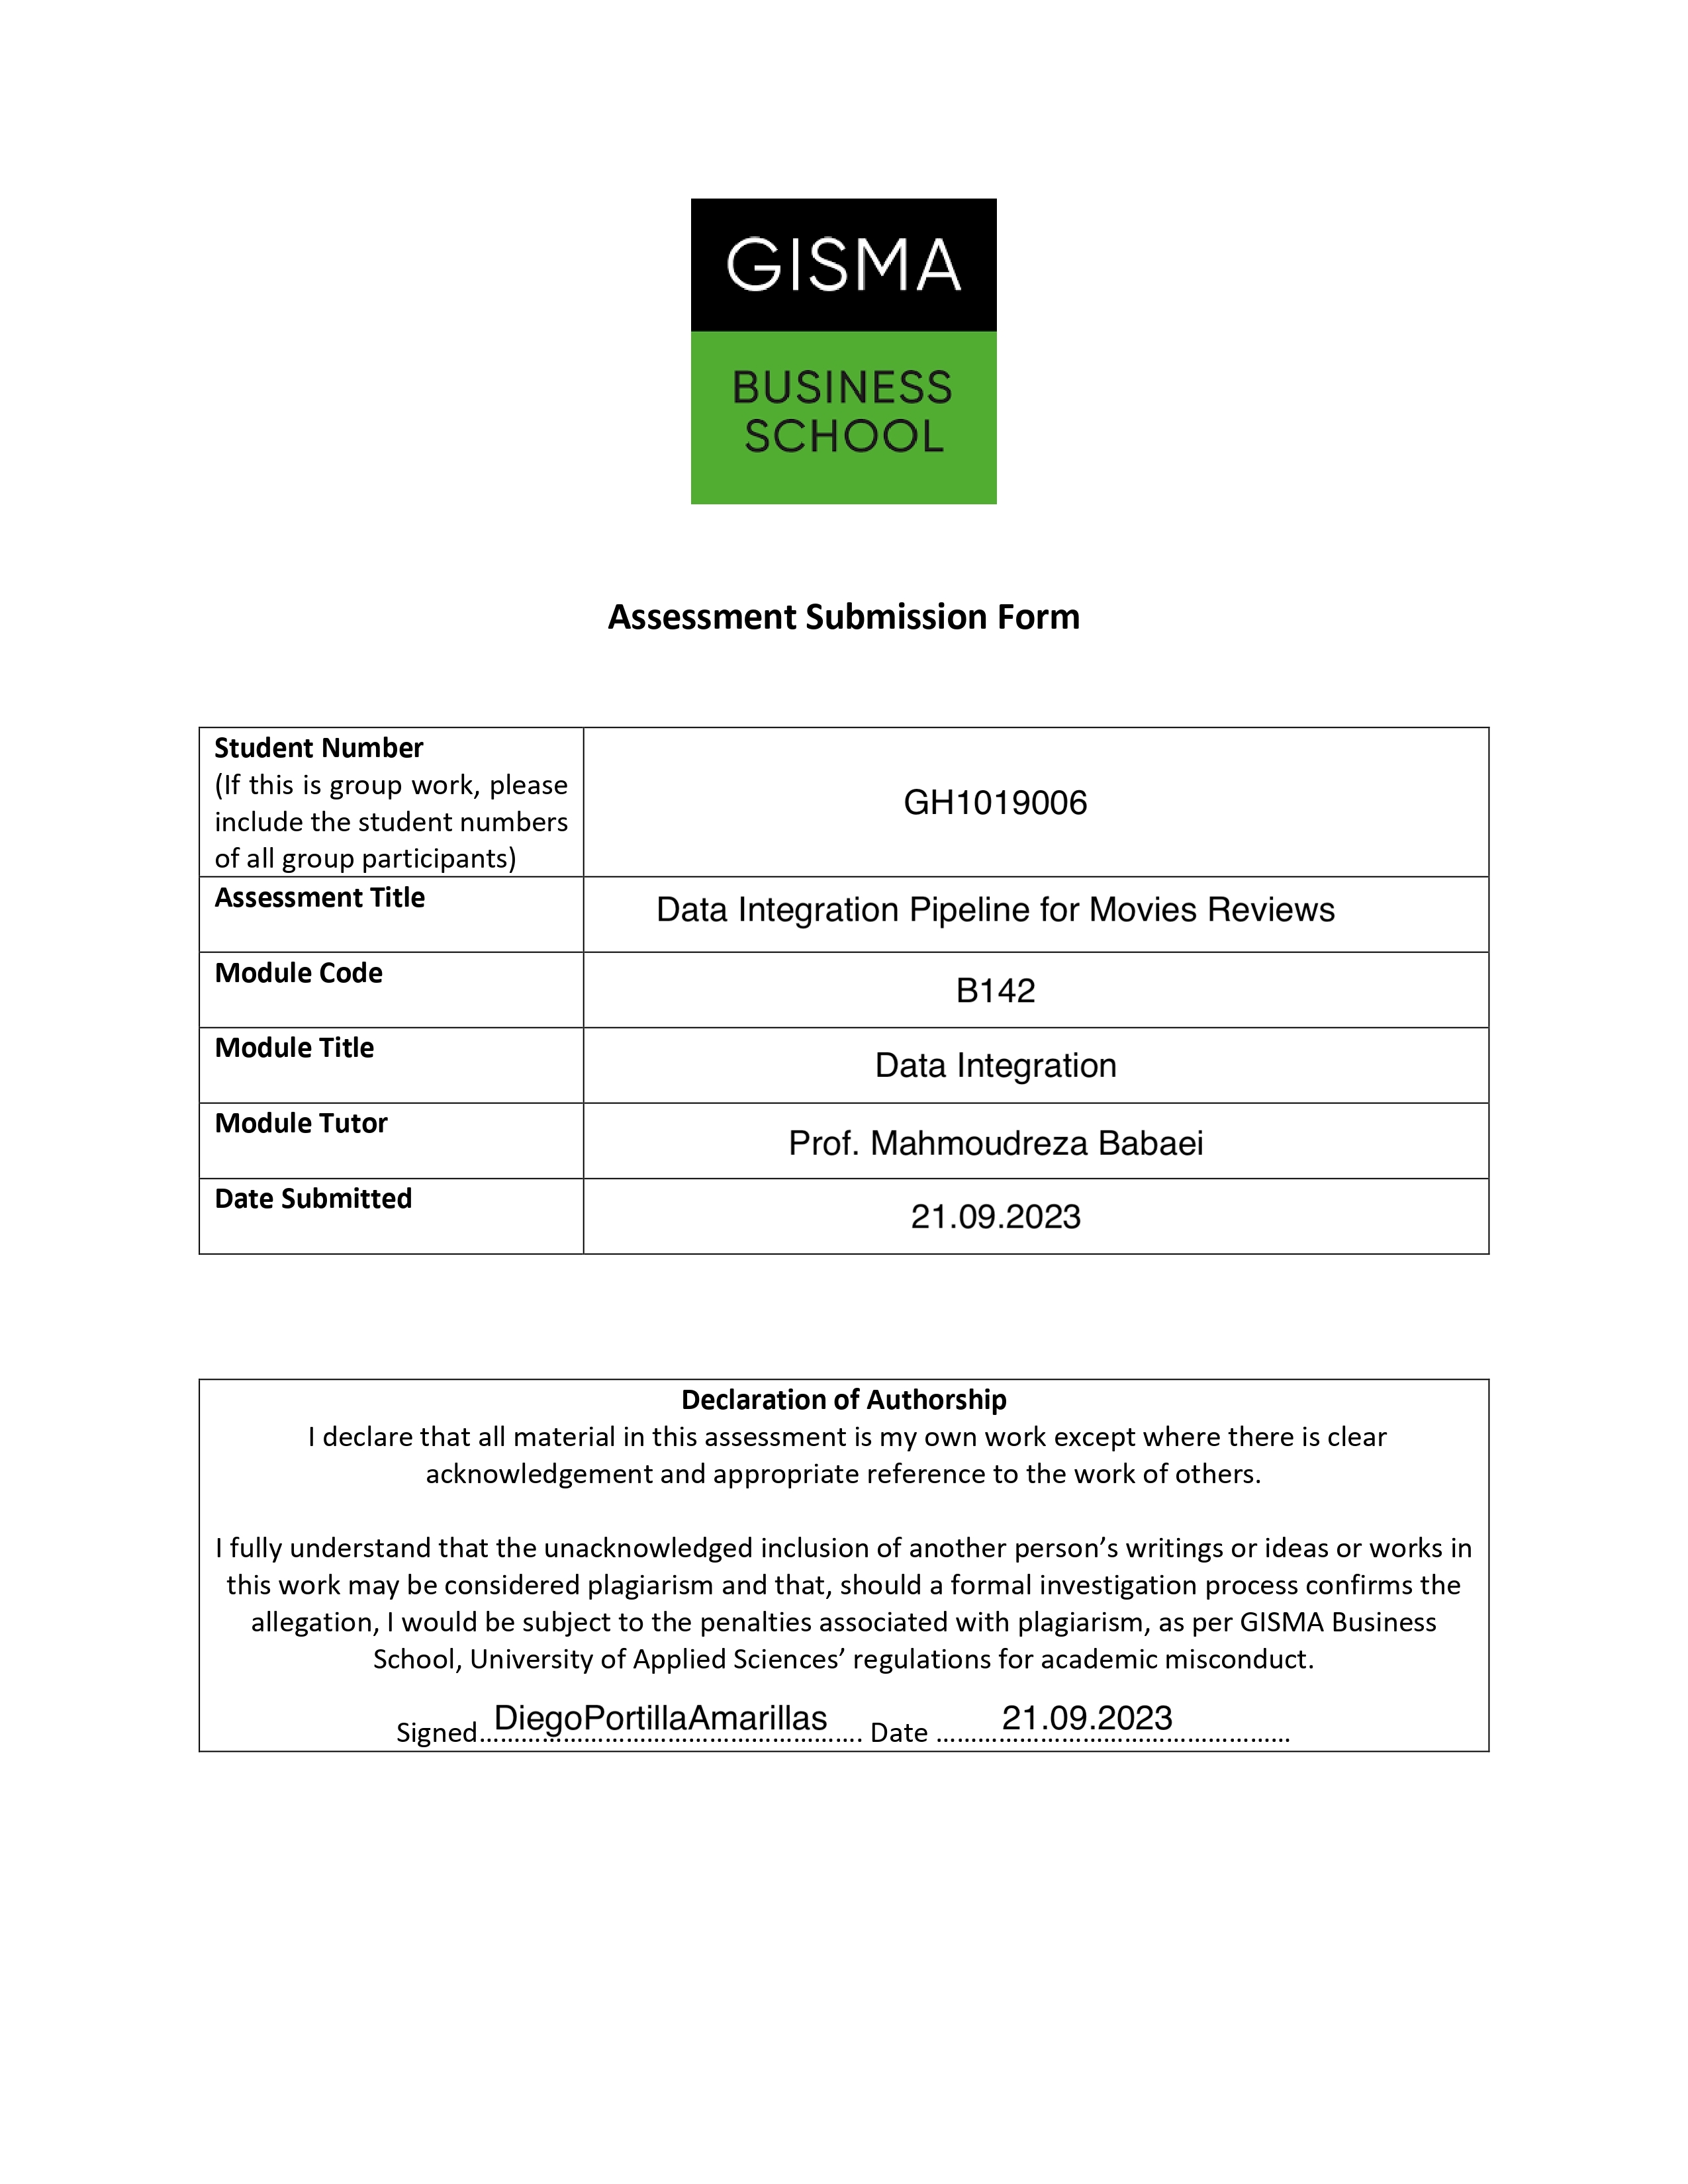

In [73]:
image_path = 'B143 Submission Form.jpg' 
display(Image(filename=image_path))